In [1]:
import tensorflow as tf

See `tensorflow/examples/speech_commands/label_wav.py`

In [2]:
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio

def load_graph(filename):
  """Unpersists graph from file as default graph."""
  with tf.gfile.FastGFile(filename, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

load_graph('frozen_graph.pb')

In [3]:
def load_labels(filename):
  """Read in labels, one label per line."""
  return [line.rstrip() for line in tf.gfile.GFile(filename)]

model_name = 'kaggle'
labels_filename = model_name + '_labels.txt'
labels_filepath = 'data/speech_commands_train/' + labels_filename
labels = load_labels(labels_filepath)

In [ ]:
import os

def predict(wav_data, sess, labels, input_layer_name='wav_data:0', output_layer_name='labels_softmax:0', num_top_predictions=1):
    softmax_tensor = sess.graph.get_tensor_by_name(output_layer_name)
    predictions, = sess.run(softmax_tensor, {input_layer_name: wav_data})

    top_k = predictions.argsort()[-num_top_predictions:][::-1]
    return [(labels[node_id], predictions[node_id]) for node_id in top_k]  # list of (label, score)

test_path = 'data/test/audio'

rows = []
with tf.Session() as sess:
    for wav in os.listdir(test_path):
        with open(test_path + '/' + wav, 'rb') as wav_file:
            wav_data = wav_file.read()
            top_prediction = predict(wav_data, sess, labels)[0]
            label, score = top_prediction
            new_row = [wav, label, score]
            rows.append(new_row)

In [5]:
import pandas as pd

predictions = pd.DataFrame(rows, columns=['fname', 'label', 'score'])
predictions.head()

,fname,label,score
0,clip_227de25a2.wav,_unknown_,0.696491
1,clip_5be3c9a8e.wav,_unknown_,0.994883
2,clip_642304206.wav,_unknown_,0.985938
3,clip_16270b7c9.wav,_silence_,0.999974
4,clip_daf840327.wav,stop,0.999995


In [6]:
predictions.count()

fname    158538
label    158538
score    158538
dtype: int64

Listen to some sample clips...

In [7]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
least_confident_predictions = pysqldf("SELECT * FROM predictions ORDER BY score ASC")
least_confident_predictions.head()

,fname,label,score
0,clip_88daf5f16.wav,down,0.112687
1,clip_e65c828d0.wav,_silence_,0.120348
2,clip_6a8d4af29.wav,left,0.120443
3,clip_0bb104623.wav,up,0.123557
4,clip_5b5c9a12d.wav,go,0.125660


In [8]:
import IPython.display as ipd
from scipy.io import wavfile

sample_rate, wav_file_data = wavfile.read(test_path + '/' + predictions['fname'][0])

In [9]:
ipd.Audio(wav_file_data, rate=sample_rate)

# Distribution of Prediction Confidence

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24b91525f8>]], dtype=object)

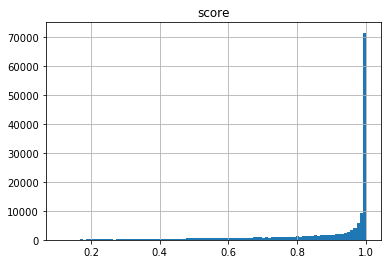

In [10]:
%matplotlib inline

predictions.hist(column='score', bins=100)

# Save to CSV

In [11]:
submission_sql_string = """
SELECT fname,
       CASE WHEN label = '_unknown_' THEN 'unknown'
            WHEN label = '_silence_' THEN 'silence'
            ELSE label 
        END AS label
  FROM predictions
"""
submission = pysqldf(submission_sql_string)

Check for unexpected labels...

In [12]:
unexpected_labels_sql_string = """
SELECT * 
  FROM submission
 WHERE label NOT IN ('unknown', 
                     'silence', 
                     'yes', 
                     'no', 
                     'up', 
                     'down', 
                     'left', 
                     'right', 
                     'on', 
                     'off', 
                     'stop', 
                     'go')
"""
pysqldf(unexpected_labels_sql_string).head()

,fname,label


In [13]:
submission.to_csv('submission.csv', index=False)